In [1]:
import psycopg2 as pg2
import pandas as pd
import math

In [2]:
print ("Connecting to SQL")
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='')

print ("Reading Dataset")
df = pd.read_sql ("""Select * from auction_full where auction_date >= """, conn)

Connecting to SQL
Reading Dataset


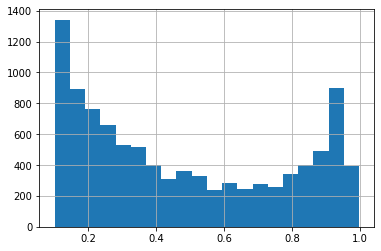

In [77]:
df.perc_to_bin[(df.perc_to_bin > .1 ) & (df.perc_to_bin < 1)&(df.giveup)].hist(bins=20)

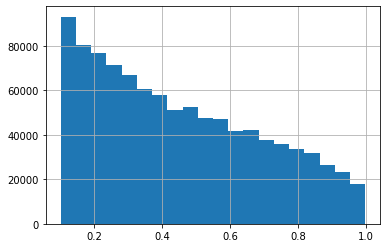

In [78]:
df.perc_to_bin[(df.perc_to_bin > .1 ) & (df.perc_to_bin < 1)&(df.giveup==False)].hist(bins=20)

In [161]:
df["bucket"]=df.perc_to_bin.apply(lambda x: int(round(int(x*300))/30.0))

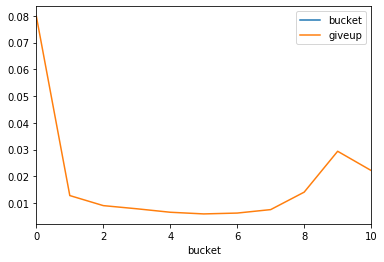

In [167]:
df.groupby("bucket").mean().loc[:,["bucket", "giveup"]].head(11).plot()

In [153]:
df.groupby("bucket").mean().loc[:,["perc_to_bin", "giveup"]].head(11)

,perc_to_bin,giveup
bucket,,
0,0.043888,0.079815
1,0.146587,0.012848
2,0.246529,0.009094
3,0.346163,0.007915
4,0.446733,0.006616
5,0.547500,0.005994
6,0.647057,0.006311
7,0.746305,0.007604
8,0.845803,0.014124


In [168]:
conn.close()

In [12]:
from BuildModel import PennyModel
import psycopg2 as pg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pickle
from datetime import datetime, date, timedelta
import importlib

In [13]:
def get_list_of_dates():

    sdate = date(2020, 2, 17)   # start date
    edate = date(2020, 2, 24)   # end date

    delta = edate - sdate       # as timedelta

    return [pd.Timestamp(sdate + timedelta(days=i)) for i in range(delta.days + 1)]
        
get_list_of_dates()

[Timestamp('2020-02-17 00:00:00'),
 Timestamp('2020-02-18 00:00:00'),
 Timestamp('2020-02-19 00:00:00'),
 Timestamp('2020-02-20 00:00:00'),
 Timestamp('2020-02-21 00:00:00'),
 Timestamp('2020-02-22 00:00:00'),
 Timestamp('2020-02-23 00:00:00'),
 Timestamp('2020-02-24 00:00:00')]

In [42]:
print ("Connecting to SQL")
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='')

print ("Reading Dataset")
df = pd.read_sql ("""Select *  from auction_full where cardtype='None' order by auctiontime""", conn)

print ("Splitting into Train/Test Sets")
#df = df.sort_values("auctiontime")
y = df['is_winner']
X = df

Connecting to SQL
Reading Dataset
Splitting into Train/Test Sets


In [43]:
def print_profit_threshold (y_test, probs, X_test):
    for thresh in np.arange(0, 1.1, .05): # threshes:
        y_pred = probs >= thresh
        cm = confusion_matrix(y_test, y_pred)
        print("*****************************")
        print("thresh:", thresh)
        acc = accuracy_score(y_test, y_pred) * 100
        prec = precision_score(y_test, y_pred) *100
        rec = recall_score(y_test, y_pred) *100
        print (f"Accuracy: {acc:.2f} Precision: {prec:.2f}  Recall:{rec:.2f} ")
        print(cm)
        true_positive_mask = (y_pred==True)&(y_test==True)
        profit = sum(X_test.cashvalue[true_positive_mask])-sum(y_pred)*.40 - sum(X_test.fee[true_positive_mask]) - sum(X_test.bid[true_positive_mask])/100
        profit_per_bid = profit/sum(y_pred)
        print(f"profit: {profit:.2f}")
        print(f"profit per bid: {profit_per_bid:.2f}")
        winners = X_test[true_positive_mask].groupby("cashvalue").count()
        print(winners.is_winner)
        print("*****************************")
        print("")

In [44]:
date_list = get_list_of_dates()


for i in range(1, len(date_list)):
    train_cut_off  = date_list[i-1]
    test_cut_off = date_list[i]
    print (train_cut_off, test_cut_off)
    X_train = X[X.auctiontime <= train_cut_off]
    y_train = y[X.auctiontime <= train_cut_off]
    X_test = X[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]
    y_test = y[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]
    #X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)#, random_state=0) 

    print ("Fitting Model")
    pm = PennyModel()
    pm.fit(X_train, y_train)

    print ("Calculating predictions")
    probs = pm.predict_proba(X_test)[:,1]
    threshes = np.unique(probs)
    threshes = threshes[threshes > .4]

    print_profit_threshold(y_test, probs, X_test)



2020-02-17 00:00:00 2020-02-18 00:00:00
Fitting Model
2. Transforming data
4. Fitting model
Calculating predictions
2. Transforming data
*****************************
thresh: 0.0
Accuracy: 0.39 Precision: 0.39  Recall:100.00 
[[   0 2586]
 [   0   10]]
profit: -64.36
profit per bid: -0.02
cashvalue
100    10
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.05
Accuracy: 0.39 Precision: 0.39  Recall:100.00 
[[   0 2586]
 [   0   10]]
profit: -64.36
profit per bid: -0.02
cashvalue
100    10
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.1
Accuracy: 0.39 Precision: 0.39  Recall:100.00 
[[   0 2586]
 [   0   10]]
profit: -64.36
profit per bid: -0.02
cashvalue
100    10
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.15000000000000002
Accuracy: 1.81 Precision: 0.39  Recall:100.00 
[[  37 2549]
 [   0   10]]
profit: -49.56
profit per bi

/home/pkgalea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pkgalea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Accuracy: 99.61 Precision: 0.00  Recall:0.00 
[[2586    0]
 [  10    0]]
profit: 0.00
profit per bid: nan
Series([], Name: is_winner, dtype: int64)
*****************************

*****************************
thresh: 0.9
Accuracy: 99.61 Precision: 0.00  Recall:0.00 
[[2586    0]
 [  10    0]]
profit: 0.00
profit per bid: nan
Series([], Name: is_winner, dtype: int64)
*****************************

*****************************
thresh: 0.9500000000000001
Accuracy: 99.61 Precision: 0.00  Recall:0.00 
[[2586    0]
 [  10    0]]
profit: 0.00
profit per bid: nan
Series([], Name: is_winner, dtype: int64)
*****************************

*****************************
thresh: 1.0
Accuracy: 99.61 Precision: 0.00  Recall:0.00 
[[2586    0]
 [  10    0]]
profit: 0.00
profit per bid: nan
Series([], Name: is_winner, dtype: int64)
*****************************

*****************************
thresh: 1.05
Accuracy: 99.61 Precision: 0.00  Recall:0.00 
[[2586    0]
 [  10    0]]
profit: 0.00
profit per bid

/home/pkgalea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pkgalea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


profit: 0.00
profit per bid: nan
Series([], Name: is_winner, dtype: int64)
*****************************

*****************************
thresh: 1.0
Accuracy: 99.49 Precision: 0.00  Recall:0.00 
[[10082     0]
 [   52     0]]
profit: 0.00
profit per bid: nan
Series([], Name: is_winner, dtype: int64)
*****************************

*****************************
thresh: 1.05
Accuracy: 99.49 Precision: 0.00  Recall:0.00 
[[10082     0]
 [   52     0]]
profit: 0.00
profit per bid: nan
Series([], Name: is_winner, dtype: int64)
*****************************

2020-02-19 00:00:00 2020-02-20 00:00:00
Fitting Model
2. Transforming data
4. Fitting model
Calculating predictions
2. Transforming data
*****************************
thresh: 0.0
Accuracy: 0.32 Precision: 0.32  Recall:100.00 
[[   0 9681]
 [   0   31]]
profit: -1901.92
profit per bid: -0.20
cashvalue
40     17
100    14
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.05
Accuracy: 0.32 Pr

/home/pkgalea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pkgalea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Fitting Model
2. Transforming data
4. Fitting model
Calculating predictions
2. Transforming data
*****************************
thresh: 0.0
Accuracy: 0.44 Precision: 0.44  Recall:100.00 
[[    0 11616]
 [    0    51]]
profit: -2429.47
profit per bid: -0.21
cashvalue
6       9
20     11
40     17
100    14
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.05
Accuracy: 0.44 Precision: 0.44  Recall:100.00 
[[    0 11616]
 [    0    51]]
profit: -2429.47
profit per bid: -0.21
cashvalue
6       9
20     11
40     17
100    14
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.1
Accuracy: 0.69 Precision: 0.44  Recall:100.00 
[[   29 11587]
 [    0    51]]
profit: -2417.87
profit per bid: -0.21
cashvalue
6       9
20     11
40     17
100    14
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.15000000000000002
Accuracy: 2.17 Precision: 0.44  Re

/home/pkgalea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pkgalea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


2. Transforming data
4. Fitting model
Calculating predictions
2. Transforming data
*****************************
thresh: 0.0
Accuracy: 0.85 Precision: 0.85  Recall:100.00 
[[    0 16154]
 [    0   139]]
profit: -3202.13
profit per bid: -0.20
cashvalue
6      38
10     31
20     38
40     17
100    15
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.05
Accuracy: 0.85 Precision: 0.85  Recall:100.00 
[[    0 16154]
 [    0   139]]
profit: -3202.13
profit per bid: -0.20
cashvalue
6      38
10     31
20     38
40     17
100    15
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.1
Accuracy: 0.88 Precision: 0.85  Recall:100.00 
[[    4 16150]
 [    0   139]]
profit: -3200.53
profit per bid: -0.20
cashvalue
6      38
10     31
20     38
40     17
100    15
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.15000000000000002
Accuracy: 2.36 Pre

/home/pkgalea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pkgalea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


2. Transforming data
4. Fitting model
Calculating predictions
2. Transforming data
*****************************
thresh: 0.0
Accuracy: 0.79 Precision: 0.79  Recall:100.00 
[[    0 20180]
 [    0   160]]
profit: -4741.40
profit per bid: -0.23
cashvalue
6      38
10     53
20     38
40     17
100    14
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.05
Accuracy: 0.79 Precision: 0.79  Recall:100.00 
[[    0 20180]
 [    0   160]]
profit: -4741.40
profit per bid: -0.23
cashvalue
6      38
10     53
20     38
40     17
100    14
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.1
Accuracy: 1.10 Precision: 0.79  Recall:100.00 
[[   63 20117]
 [    0   160]]
profit: -4716.20
profit per bid: -0.23
cashvalue
6      38
10     53
20     38
40     17
100    14
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.15000000000000002
Accuracy: 2.56 Pre

/home/pkgalea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pkgalea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Fitting Model
2. Transforming data
4. Fitting model
Calculating predictions
2. Transforming data
*****************************
thresh: 0.0
Accuracy: 1.13 Precision: 1.13  Recall:100.00 
[[   0 4798]
 [   0   55]]
profit: -799.73
profit per bid: -0.16
cashvalue
6      15
10     16
20     13
40      7
100     4
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.05
Accuracy: 1.13 Precision: 1.13  Recall:100.00 
[[   0 4798]
 [   0   55]]
profit: -799.73
profit per bid: -0.16
cashvalue
6      15
10     16
20     13
40      7
100     4
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.1
Accuracy: 1.50 Precision: 1.14  Recall:100.00 
[[  18 4780]
 [   0   55]]
profit: -792.53
profit per bid: -0.16
cashvalue
6      15
10     16
20     13
40      7
100     4
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.15000000000000002
Accuracy: 4.18 Prec

/home/pkgalea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pkgalea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [27]:
y_pred = probs >= .8

X_test[y_pred].shape

(421, 78)

Plotting features


Text(0.5, 0, 'Average contribution to information gain')

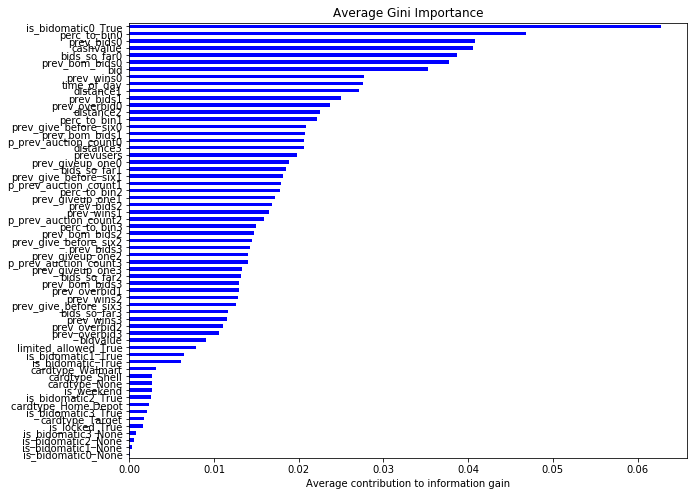

In [17]:

print ("Plotting features")
# Plot the feature importance
feat_scores = pm.get_feature_scores()
feat_scores = feat_scores.sort_values()
fig, ax = plt.subplots()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain')



In [157]:
X_test[(probs > .6)].groupby("cardtype").is_winner.count().head(50)

cardtype
Amazon        13797
Home Depot     1369
None          14946
Shell          6251
Target         3643
Walmart        5528
Name: is_winner, dtype: int64

In [158]:
X_test["prob"] = probs > .6

/home/pkgalea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [165]:
X_test.groupby(["is_bidomatic0","prob"]).mean()

auctionid  is_winner  cashvalue  cardvalue       fee  \
is_bidomatic0 prob                                                             
False         False  5.579744e+08   0.004597  63.435255  37.202811  1.276415   
              True   5.314351e+08   0.016228  41.722465  24.174205  0.943895   
True          False  5.565080e+08   0.001949  63.800840  39.593450  1.389779   
              True   5.303516e+08   0.010489  37.161703  23.826247  0.945472   

                      bidvalue  limited_allowed  is_locked         bid  \
is_bidomatic0 prob                                                       
False         False  65.581111         0.309497   0.294496  420.056325   
              True   43.870651         0.277433   0.221974  212.985805   
True          False  60.518476         0.249776   0.213906  346.425474   
              True   33.338640         0.211151   0.300181  239.660111   

                     is_bidomatic  ...  bom_bids_so_far3  bom_streak3  \
is_bidomatic0 prob                 ...                                  
False         False      0.628294  ...         28.679839    15.617112   
              True       0.720636  ...         14.373425     7.421713   
True          False      0.805810  ...         25.001725    13.043358   
              True       0.830430  ...         27.252327    15.954209   

                     perc_to_bin3  p_prev_auction_count3  prev_overbid3  \
is_bidomatic0 prob                                                        
False         False      0.236595             115.474403       0.069192   
              True       0.214227             107.473748       0.051186   
True          False      0.197456             110.687271       0.059939   
              True       0.348683             104.070326       0.053110   

                     prev_giveup_one3  prev_give_before_six3  prev_wins3  \
is_bidomatic0 prob                                                         
False         False          0.248195               0.464856    0.140230   
              True           0.270622               0.514245    0.120976   
True          False          0.259120               0.485300    0.129384   
              True           0.269415               0.510400    0.118611   

                     prev_bids3  prev_bom_bids3  
is_bidomatic0 prob                               
False         False   37.159819       28.527811  
              True    26.834702       20.325800  
True          False   33.318953       25.748146  
              True    26.303400       20.024208  

[4 rows x 67 columns]

In [148]:
X_test.groupby("prev_wins_bin").is_winner.mean()

prev_wins_bin
(-0.001, 0.05]    0.008728
(0.05, 0.1]       0.006418
(0.1, 0.15]       0.005427
(0.15, 0.2]       0.003929
(0.2, 0.25]       0.002835
(0.25, 0.3]       0.002669
(0.3, 0.35]       0.002410
(0.35, 0.4]       0.002361
(0.4, 0.45]       0.001622
(0.45, 0.5]       0.003214
(0.5, 0.55]       0.001992
(0.55, 0.6]       0.002457
(0.6, 0.65]       0.000958
(0.65, 0.7]       0.002618
(0.7, 0.75]       0.000000
(0.75, 0.8]            NaN
(0.8, 0.85]            NaN
(0.85, 0.9]            NaN
(0.9, 0.95]            NaN
(0.95, 1.0]       0.004425
Name: is_winner, dtype: float64